# Developing functions for computing the FFDI drought factor via the KBDI

In [1]:
import xarray as xr

import numpy as np

from src.prepare_data import _open

import matplotlib.pyplot as plt

In [2]:
%load_ext lab_black

## Cluster

In [27]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

Dask daskboard link: http://10.6.56.28:8787/status


## Develop on some AGCD data

In [4]:
prep_data = False

if prep_data:
    agcd = _open.AGCD(["precip", "tmax"], None, None)

    precip = agcd[["precip"]].sel(time=slice("1960", None)).chunk({"time": -1})
    precip.to_zarr("agcd_precip.zarr", mode="w")

    tmax = agcd[["tmax"]].sel(time=slice("1960", None)).chunk({"time": -1})
    tmax.to_zarr("agcd_tmax.zarr", mode="w")

precip = xr.open_zarr("agcd_precip.zarr")
tmax = xr.open_zarr("agcd_tmax.zarr")

## Calculate KBDI

In [28]:
from numba import jit
import dask.array as dsa


def calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day=False):
    """
    Calculate the Keetch-Byram drought index, defined as:

        KBDI_n = KBDI_n-1 − Peff + ET

    Peff is the previous 24-hour rainfall amount, precip_n, decreased by an amount to allow
    for interception and/or runoff:

        Peff = precip_n - (interception/runoff)

    where the interception and/or runoff is approximated as the first 5 mm within consecutive
    days with nonzero rainfall.

    ET is the evapotransporation, estimated as:

        ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
             -------------------------------------------------------------------- * 10 ** (-3)
                          1 + 10.88 * exp(-0.00173 * precip_annual)

    where tmax_n-1 is the previous day's max temperature and precip_annual is the mean annual
    rainfall.

    Parameters
    ----------
    precip : numpy array with shape [..., N]
        Array of daily precipitation with the last axes corresponding to the time dimension
    tmax : numpy array with shape [..., N]
        Array of max daily temperature with the last axes corresponding to the time dimension
    precip_annual : numpy array with shape [...]
        Array containing the mean annual rainfall. Usually this is computed as the average over
        a period of years corresponding the calculation period of the KBDI
    use_precip_from_previous_day : boolean, optional
        If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
        KBDI_n. See Notes below.

    Notes
    -----
    Daily values represent different things in different datasets. For example:
      - the daily precipitation values in AGCD represent the previous 24-hour rainfall at 9am
        and the daily tmax/tmin values represent the max/min temperatures over the subsequent
        24-hours from 9am. Thus it is appropriate to use precip_n and t_max_n-1 as above in
        order to calculate KBDI_n from the previous 24-hour rainfaill and previous day's max
        temperature.
      - both the daily precipitation and daily max temperature values are assigned to 12pm on
        a given day in CAFE and correspond to the 24-hour period centred on that time. Thus,
        one could argue that it is appropriate to use precip_n-1 and t_max_n-1 (or precip_n
        and tmax_n) to calculate KBDI_n.
      - Daily reanalysis data (e.g. JRA55) is otfen referenced against the inital forecast
        time and the precip and tmax values correspond to the 24-hour period subsequent to the
        reference time. Thus, it is appropriate to use precip_n-1 and tmax_n-1 to calculate
        KBDI_n.

    References
    ----------
    Finkele et al. 2006 (on calculation):
        https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
    Holgate et al. 2017 (on calculation):
        https://www.publish.csiro.au/wf/WF16217
    Dolling et al. 2005 (on initialisation):
        https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
    """

    @jit(nopython=True)
    def _calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day):
        """
        Workhorse function to calculate the KBDI

        Parameters
        ----------
        precip : numpy array with shape [..., N]
            Array of daily precipitation with the last axes corresponding to the time dimension
        tmax : numpy array with shape [..., N]
            Array of max daily temperature with the last axes corresponding to the time dimension
        precip_annual : numpy array with shape [...]
            Array containing the mean annual rainfall. Usually this is computed as the average over
            a period of years corresponding the calculation period of the KBDI
        use_precip_from_previous_day : boolean, optional
            If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
            KBDI_n.

        Note, I tried writing a version of this function using dask='allowed', rather than
        dask='parallelized', which is generally a better approach. However, the code relied on hacks
        to use apply_gufunc or map_blocks, so I opted for this simpler approach instead. See
        https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1c3743d99d564a031710d03bfffe8995b3cde3f4/
            notebooks/exploratory/calculate_KBDI.ipynb
        """

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall
            """
            remaining_runoff = np.where(precip > 0, remaining_runoff, 5.0)
            runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
            Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * precip_annual)
            return 1e-3 * term_1 * term_2 / term_3

        KBDI = np.zeros_like(precip)

        remaining_runoff = 5.0 * np.ones_like(precip[..., 0])
        if not use_precip_from_previous_day:
            _, remaining_runoff = calculate_Peff(precip[..., 0], remaining_runoff)

        for i in range(1, KBDI.shape[-1]):
            precip_curr = (
                precip[..., i - 1] if use_precip_from_previous_day else precip[..., i]
            )
            Peff, remaining_runoff = calculate_Peff(precip_curr, remaining_runoff)
            ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
            KBDI_curr = KBDI[..., i - 1] - Peff + ET
            KBDI[..., i] = np.where(KBDI_curr < 0, 0, KBDI_curr)

        return KBDI

    KBDI = xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        use_precip_from_previous_day,
        input_core_dims=[["time"], ["time"], [], []],
        output_core_dims=[["time"]],
        dask="parallelized",
        output_dtypes=[precip.dtype],
    )

    KBDI = KBDI.rename("KBDI")
    KBDI.attrs["long_name"] = "Keetch-Byram Drought Index (KBDI)"
    KBDI.attrs["standard_name"] = "Keetch-Byram Drought Index"

    return KBDI

In [29]:
prep_data = False

if prep_data:
    precip_annual = precip.resample(time="A").sum().mean("time")

    KBDI = calculate_KBDI(
        precip["precip"],
        tmax["tmax"],
        precip_annual["precip"],
    ).to_dataset()

    KBDI.to_zarr("agcd_KBDI.zarr", mode="w")

KBDI = xr.open_zarr("agcd_KBDI.zarr")

CPU times: user 4.52 s, sys: 863 ms, total: 5.38 s
Wall time: 52.6 s


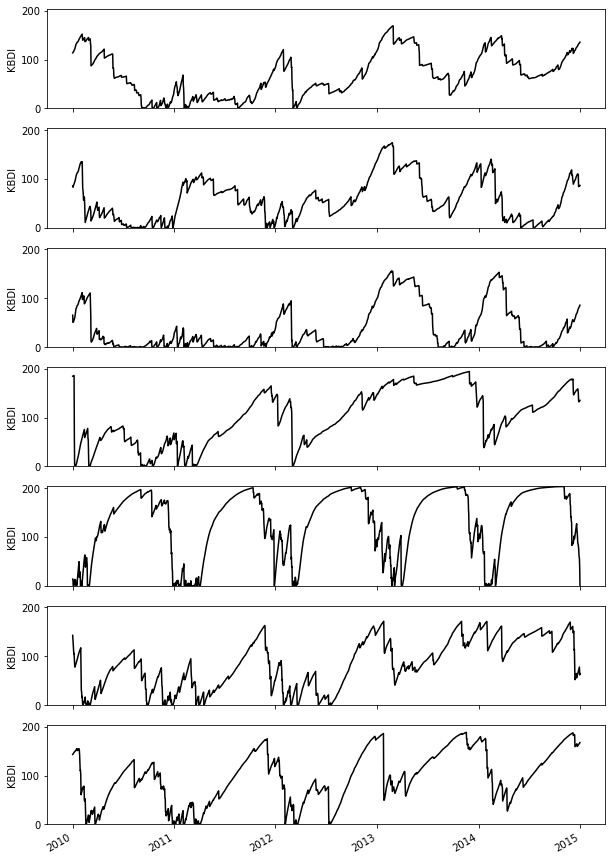

In [30]:
%%time
locations = [{"lon": 146.4, "lat": -34.6},
             {"lon": 148.2, "lat": -32.7},
             {"lon": 145.2, "lat": -36.9},
             {"lon": 133.6, "lat": -22.5},
             {"lon": 132.4, "lat": -14.5},
             {"lon": 148.2, "lat": -23.6},
             {"lon": 146.3, "lat": -20.0}]

fig, axs = plt.subplots(len(locations), 1, sharex=True, figsize=(10,15))
for ax, loc in zip(axs, locations):
    KBDI["KBDI"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(ax=ax, color="k")
    ax.set_ylim(0, 203.5)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("KBDI")

## Calculate Drought factor

In [47]:
def test(ds):
    print(ds)

In [50]:
KBDI.rolling(time=20, min_periods=20).

{'KBDI': DataArrayRolling [time->20]}